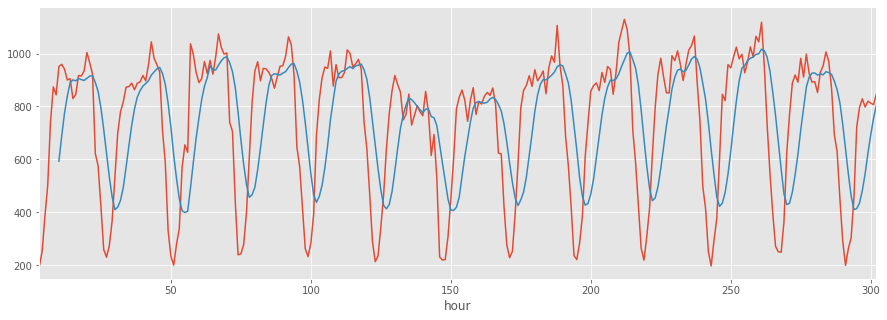

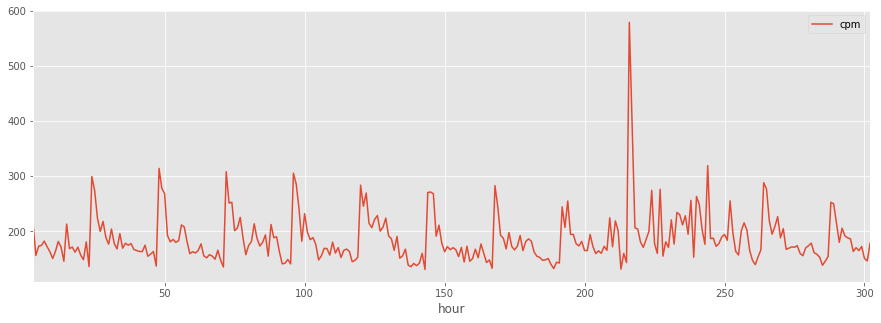

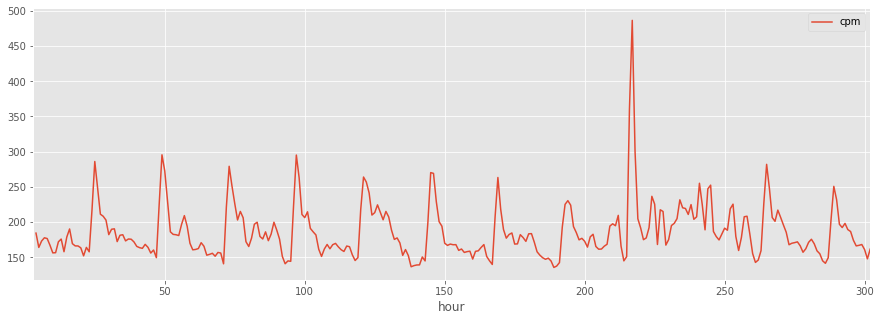

In [1]:
# data discovery and data read

import pandas as pd
import numpy as np

#############################################################
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

################################################################

import pandas as pd
import numpy as np

users = pd.read_csv("users.tsv","\t")

history = pd.read_csv("history.tsv","\t")

validate_answers = pd.read_csv("validate_answers.tsv","\t")

validate = pd.read_csv("validate.tsv","\t")



#print(history.sort_values(by='hour').count())
#print()

N = 300

history.groupby('hour').size().head(N).plot()

history.groupby('hour').size().head(N).rolling(window=8).mean().plot()


history.groupby('hour')[['cpm']].mean().head(N).plot()

history.groupby('hour')[['cpm']].mean().head(N).rolling(window=2).mean().plot()



In [190]:
# some preparations, make hours 24x and delta

validate = validate.assign(hour = validate['hour_end']-validate['hour_start']+1)

validate = validate.assign(sex = 0, age = 0, town = 0)

# make some magic with time 
validate['hour_start'] = validate['hour_start'] % (24*7*4)
validate['hour_end'] =  validate['hour_start'] + validate['hour']-1

usersT = users.values.T

print(usersT)

# users to npy for faster reading
np.save('usersT.npy', usersT)
loaded = np.load('usersT.npy')

print(loaded)

### users - > validate
age_bins = list()
abins = [0, 13, 15, 18, 19, 20, 21, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 45, 50, 55, 60, 65, 70, 95, 140]

for i in range(len(validate.index)):
    validate.loc[i,'sex'] = usersT[1][list(map(int, validate['user_ids'][i].split(',')))].mean()
    
    age_array = usersT[2][list(map(int, validate['user_ids'][i].split(',')))]
    
    age_bins.append(np.histogram(age_array, bins=abins)[0] * 100.0/len(age_array))
        
    validate.loc[i,'age'] = age_array.mean()
    validate.loc[i,'age_min'] = age_array.min()
    validate.loc[i,'age_max'] = age_array.max()
    
    validate.loc[i,'town'] = usersT[3][list(map(int, validate['user_ids'][i].split(',')))].mean()
    


[[    0     1     2 ... 27766 27767 27768]
 [    2     1     2 ...     2     2     1]
 [   19     0    24 ...    21    17    30]
 [    0     1     2 ...  1953     0     0]]
[[    0     1     2 ... 27766 27767 27768]
 [    2     1     2 ...     2     2     1]
 [   19     0    24 ...    21    17    30]
 [    0     1     2 ...  1953     0     0]]


In [ ]:
### make stats from history

# 24 hours cycle and 24*7
history['hour24'] = history['hour'] % 24
history['hour168'] = history['hour'] % 168


usersH = []
usersCPMmin = []
usersCPMmax = []
usersHours = []

usersCPM24 = []
usersCPM168 = []

usersHours24 = []
usersHours168 = []

usersViews24 = []
usersViews168 = []

# 	user_id 	sex 	age 	city_id

import time
start_time = time.time()

for i in range(len(users.index)):
    t = [0] # count of user X publisher views
    t1 = [0] # cpm min by user and publisher
    t2 = [0] # cpm max by user and publisher
    t3 = [[0]] # list of 24 hours with views, ex. [11,20,23]
    
    t4 = [[0]] # users X publishers x 0..23 hours
    t5 = [[0]] # users X publishers x 0..167 hours
    
    t6 = [[0]] # hours24 with views
    t7 = [[0]] # hours167 with views
    
    t8 = [[0]] # users views by 24 hours [0,0, ..., 324234] shape is (1,24)
    t9 = [[0]] # users views by 168 hours ...  shape is (1,168)
    
    
    for p in range(1,22):
        curr_slice = history[(history['user_id'] == i)&(history['publisher'] == p)]
        t.append(curr_slice.count()[0])
        t1.append(curr_slice['cpm'].min())
        t2.append(curr_slice['cpm'].max())
        t3.append(list(set(map(lambda x: x % 24, sorted(curr_slice['hour'].values)))))
        
        tt4 = [0] * 24
        tt6 = []
        tt8 = [0] * 24
        
        for q in curr_slice.groupby(by='hour24'):
            tt4[q[0]] = q[1]['cpm'].mean()
            tt6.append(q[0]) # hour with view 
            tt8[q[0]] = q[1]['cpm'].count()
                
        t4.append(tt4)
        t6.append(tt6)
        t8.append(tt8)
        
        tt5 = [0] * 168
        tt7 = []
        tt9 = [0] * 168
        
        for q in curr_slice.groupby(by='hour168'):
            tt5[q[0]] = q[1]['cpm'].mean()
            tt7.append(q[0])
            tt9[q[0]] = q[1]['cpm'].count()

  
        t5.append(tt5)
        t7.append(tt7)
        t9.append(tt9)

    usersH.append(t)
    
    usersCPMmin.append(t1)
    usersCPMmax.append(t2)

    usersHours.append(t3)
    
    usersCPM24.append(t4)
    
    usersCPM168.append(t5)
    
    usersHours24.append(t6) ### check if is it usersHours
    usersHours168.append(t7)
    
    usersViews24.append(t8)
    usersViews168.append(t9)
    
    if (i%1000 == 0):
        print(i, " - ",time.time() - start_time)



usersH = np.array(usersH)

np.save('usersH.npy', usersH) #np array

usersH1 = []
for l in usersH:
    t = list(map(lambda x: 1 if x>0 else 0,l))
    usersH1.append(t)

usersH1 = np.array(usersH1)
np.save('usersH1.npy', usersH1)


usersCPMmin = np.nan_to_num(np.array(usersCPMmin), copy=True)
np.save('usersCPMmin.npy', usersCPMmin)

usersCPMmax = np.nan_to_num(np.array(usersCPMmax), copy=True)
np.save('usersCPMmax.npy', usersCPMmax)

usersHours = np.nan_to_num(np.array(usersHours), copy=True)
np.save('usersHours.npy', usersHours)


usersCPM24 = np.nan_to_num(np.array(usersCPM24), copy=True)
np.save('usersCPM24.npy', usersCPM24)

usersCPM168 = np.nan_to_num(np.array(usersCPM168), copy=True)
np.save('usersCPM168.npy', usersCPM168)


usersHours24 = np.nan_to_num(np.array(usersHours24), copy=True)
np.save('usersHours24.npy', usersHours24)

usersHours168 = np.nan_to_num(np.array(usersHours168), copy=True)
np.save('usersHours168.npy', usersHours168)


usersViews24 = np.nan_to_num(np.array(usersViews24), copy=True)
np.save('usersViews24.npy', usersViews24)

usersViews168 = np.nan_to_num(np.array(usersViews168), copy=True)
np.save('usersViews168.npy', usersViews168)


print('done!')

0  -  0.19999408721923828
1000  -  211.94974756240845
2000  -  424.7542417049408
3000  -  639.4154815673828
4000  -  876.0623126029968
5000  -  1078.1662385463715
6000  -  1285.3917140960693
7000  -  1483.2846865653992
8000  -  1686.8640043735504
9000  -  1889.1137290000916
10000  -  2088.5814895629883
11000  -  2290.1747426986694
12000  -  2490.949763774872
13000  -  2692.9212040901184
14000  -  2909.4251837730408
15000  -  3129.3708176612854
16000  -  3329.991653442383
17000  -  3530.495950460434


На 26.02.20:

взяли среднее количество показов, с ним уже скор 345

показы идут некоторое количество часов, взяли количество часов hour_end-hour_start, разделили на среднее кол-во часов, скор стал 150

дальше попробовал то же самое сделать с аудиторией, но скор только ухудшился (что и логично, разбросы по аудитории гораздо более нелинейны, чем по времени)

следующее, что делаем - оцениваем среднюю ценность каждого часа, у нас есть день недели и час, т.е. массив от 0 до (24 * 7 - 1) и для каждого такого часа должна быть своя ценность - среднее кол-во по всей неделе

Дальше обучаем модели)


На 01.03.20:

обучил некоторе количество моделей, лучший скор 59

юзеров и паблишеров представил в виде векторов, count vectorizer

из 4 файлов задействовано по сути 2, и то - не целиком

подключил к контейнеру catboost, lightgbm, xgboost, любую либу можем загрузить

лучший регрессор - оказался случайный лес

2DO:

-перебрать этот файл, сделать последовательные операции

-полностью пройтись по устройству всех 4 файлов, осознать схему взаимодействия целиком

-выкинуть юзеров, которым ничего не показывается

-продолжить тесты с hour_start % (24*7)

-разобраться с catboost, в теории он должен помочь. параметр cat_features отвечает за категориальные фичи, я добавил их, но скор только вырос

-разобраться с max_features в randomforestclassificator, возможно стоит уменьшить

[18768, 13176, 8280, 7892, 10208, 14552, 21520, 28536, 31396, 32320, 33056, 34084, 33696, 34716, 33924, 34344, 34364, 35404, 37000, 37164, 39116, 37388, 34324, 25000, 21056, 14468, 8820, 8532, 10344, 14048, 21616, 28516, 31508, 33012, 33420, 33692, 33432, 32832, 33932, 34628, 34344, 34912, 37088, 38496, 40408, 39520, 36192, 27092, 21648, 13992, 9100, 8388, 10204, 14308, 21896, 29108, 32452, 35312, 34356, 33980, 34308, 34912, 34876, 34836, 35896, 35564, 37124, 39212, 39660, 40320, 36328, 27888, 21012, 14732, 9284, 8176, 10156, 14460, 21108, 28864, 32772, 33952, 34240, 34784, 34816, 35092, 34280, 33408, 35580, 36716, 36968, 37772, 39836, 40568, 36120, 26936, 20564, 14432, 9124, 8316, 10308, 14132, 21724, 28704, 33036, 35008, 35324, 35572, 34840, 35236, 34664, 34516, 34764, 35652, 35460, 36300, 36736, 37284, 34564, 27464, 22168, 15368, 9764, 7916, 9032, 12004, 17372, 25152, 29012, 32692, 32668, 31848, 30408, 30164, 30216, 29796, 30032, 29216, 31360, 32612, 32724, 34224, 31556, 26208, 2366

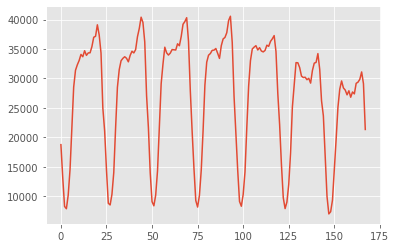

In [303]:
# views on week and hours

hours_views = []

for i in range(0, 24*7):
    hours_views.append(history.loc[history['hour'] % (24*7) == i].size)
    
print(hours_views)

plt.plot(hours_views)



In [536]:
## make new features, stats, means, vectorize&stack
# in out we have trainX and Y1,Y2,y3

from scipy.sparse import coo_matrix, hstack, vstack
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 

validate['publishers_size'] = 0

validate['views_sum'] = 0

validate['publishers_size'] = validate['publishers_size'].astype('UInt8')

validate['views_sum'] = validate['views_sum'].astype('int')

validate['p_history'] = 0
validate['p_history1'] = 0

validate['cpmMinMin'] = 0
validate['cpmMinMea'] = 0

validate['cpmMaxMax']=0
validate['cpmMaxMea']=0

validate['cpmMaxMaxi']=0

validate['cpmAVE'] = 0

def make_hours(begin,delta):
    r=np.empty(24);
    end = begin + delta
    
    begin1 = begin % 24
    
    counts = (delta - (24 - begin1)) // 24
    tail = (delta - (24 - begin1)) % 24
    
    r.fill(counts)
    for i in range(begin1, 24):
        r[i] = r[i] + 1
    for i in range(0, tail):
        r[i] = r[i] + 1
    return r


for i in range(len(validate.index)):
    
    r_hours = make_hours(validate.loc[i,'hour_start'],validate.loc[i,'hour'])
    
    publishes_ids = list(map(int,validate['publishers'][i].split(',')))

    p_s = int(len(publishes_ids))
    
    probable_views = 0
    probable_views1 = 0
    
    cpmMinMin = 9999999
    cpmMinMea = 0
    
    cpmMaxMax = -1
    cpmMaxMea = 0
    
    CPMxHour = 0
    CPMxHour1 = 0
    CPMxHour2 = 0
    CPMxHour3 = 0
    CPMxHour4 = 0
    
    
    for uid in map(int, validate.iloc[i]['user_ids'].split(',')):
        probable_views = probable_views + usersH[uid][publishes_ids].sum()
        #probable_views1 = probable_views1 + usersH1[uid][publishes_ids].sum()
        ''''''
        ### CPMmin
        t = usersCPMmin[uid][publishes_ids]      
        tmin = t.min()
      
        if (cpmMinMin > tmin):
            cpmMinMin = tmin
            
        #cpmMinMea = cpmMinMea + t.sum()
            
        ### CPMmax 
        t = usersCPMmax[uid][publishes_ids]      
        tmax = t.max()
      
        if (cpmMaxMax < tmax):
            cpmMaxMax = tmax
            
        #cpmMaxMea = cpmMaxMea + t.sum()
        
        for pp in publishes_ids:
            for t in usersHours24[uid][pp]:
                cur_CPM = usersCPM24[uid][pp][t]
                if (cur_CPM > 0):
                    if (cur_CPM < validate.loc[i,'cpm']):
                        CPMxHour = CPMxHour + 1 # tasks.loc[i,'cpm'] / cur_CPM
                        CPMxHour1 = CPMxHour1 + 1                        
                        CPMxHour2 = CPMxHour2 + 1
                        
                        CPMxHour3 = CPMxHour3 + r_hours[t]
                        CPMxHour4 = CPMxHour4 + usersViews24[uid][pp][t]
                        
                    elif (cur_CPM == validate.loc[i,'cpm']):
                        #CPMxHour = CPMxHour + 1
                        CPMxHour1 = CPMxHour1 + 0.5                        
                        CPMxHour2 = CPMxHour2 + 1
                        
                        CPMxHour3 = CPMxHour3 + 0.5 * r_hours[t]
                        CPMxHour4 = CPMxHour4 + 0.5 * usersViews24[uid][pp][t]
                    else:                     
                        CPMxHour2 = CPMxHour2 + validate.loc[i,'cpm'] / cur_CPM
                        CPMxHour3 = CPMxHour3 + r_hours[t] * validate.loc[i,'cpm'] / (2 * cur_CPM)
                        CPMxHour4 = CPMxHour4 + usersViews24[uid][pp][t] * validate.loc[i,'cpm'] / (2 * cur_CPM)
            
    validate.loc[i,'p_history'] = probable_views / (p_s * validate.iloc[i]['audience_size'])
    
    #validate.loc[i,'p_history1'] = probable_views1 / (p_s * validate.iloc[i]['audience_size'])
    ''' '''
    validate.loc[i,'cpmMinMin'] = cpmMinMin / validate.loc[i,'cpm'] # / ??? / validate.loc[i,'cpm'] ???
    
    #validate.loc[i,'cpmMinMea'] = cpmMinMea / probable_views1 / validate.loc[i,'cpm'] # / ??? / validate.loc[i,'cpm'] ???

    validate.loc[i,'cpmMaxMax'] = cpmMaxMax / validate.loc[i,'cpm'] # / ??? / validate.loc[i,'cpm'] ???
    #validate.loc[i,'cpmMaxMea'] = cpmMaxMea / probable_views1 / validate.loc[i,'cpm'] # / ??? / validate.loc[i,'cpm'] ???

    validate.loc[i,'cpmMaxMaxi'] =  validate.loc[i,'cpm'] / cpmMaxMax # / ??? / validate.loc[i,'cpm'] ???

    validate.loc[i,'cpmAVE'] = (validate.loc[i,'cpmMinMin'] +  validate.loc[i,'cpmMaxMax']) / 2
    
    validate.loc[i,'CPMxHour'] = CPMxHour
    validate.loc[i,'CPMxHour1'] = CPMxHour1
    validate.loc[i,'CPMxHour2'] = CPMxHour2
    validate.loc[i,'CPMxHour3'] = CPMxHour3
    validate.loc[i,'CPMxHour4'] = CPMxHour4
    
    validate.loc[i,'publishers_size'] = p_s
    
    t = 0
    for h in range(int(validate.iloc[i]['hour_start']),int(validate.iloc[i]['hour_end'])+1):
        t = t + hours_views[h %(24*7)]
    
    validate.loc[i,'views_sum'] = t
    

    

###############################################

import joblib
from shutil import copyfile


v1 = CountVectorizer(token_pattern='[0-9]+', dtype='UInt8')
v2 = CountVectorizer(token_pattern='[0-9]+', dtype='UInt8')

#

p_ids = v1.fit_transform(validate['publishers'])

print(v1.get_feature_names()," - ", len(v1.get_feature_names()))
print(p_ids.shape)

_ = joblib.dump(v1, 'v1.pkl', compress=9)

u_ids = v2.fit_transform(validate['user_ids'])

print(v2.get_feature_names(), len(v2.get_feature_names()))
print(u_ids.shape)

_ = joblib.dump(v2, 'v2.pkl', compress=9)


from shutil import copyfile

# copy vectorizers to prod
copyfile('v1.pkl', './dtest/v1.pkl')
copyfile('v2.pkl', './dtest/v2.pkl')

##################### do not use users size because we have audience_size
#validate
#features = ['cpm', 'hour_start', 'hour_end','audience_size','hour','publishers_size', 'views_sum','sex','age','age_min','age_max','town','p_history', 'p_history1', 'CPMxHour','CPMxHour1','CPMxHour2']

features = ['cpm', 'hour_start', 'hour_end','audience_size','hour','publishers_size', 'views_sum','sex','age','age_min','age_max','town','p_history', 'cpmMinMin', 'cpmMaxMax', 'cpmMaxMaxi','cpmAVE','CPMxHour','CPMxHour1','CPMxHour2', 'CPMxHour3', 'CPMxHour4']

#features = ['cpm', 'hour_start', 'hour_end','audience_size','hour','publishers_size', 'views_sum','sex','age','age_min','age_max','town','p_history', 'p_history1', 'cpmMinMin', 'cpmMinMea', 'cpmMaxMax', 'cpmMaxMea', 'cpmMaxMaxi','cpmAVE','CPMxHour','CPMxHour1','CPMxHour2']
#features = ['cpm', 'hour_start', 'hour_end','audience_size','hour','publishers_size', 'views_sum', 'sex', 'town', 'p_history', 'p_history1', 'cpmMinMin', 'cpmMinMea', 'cpmMaxMax', 'cpmMaxMea', 'cpmMaxMaxi','cpmAVE','CPMxHour','CPMxHour1','CPMxHour2'] # age in bins

trainX = validate[features].values 

# train(features + publishers vector + user_ids vector + age_bins)
trainX = np.hstack((trainX,p_ids.toarray(),u_ids.toarray(),np.array(age_bins)))

print(trainX)

Y1 = validate_answers[['at_least_one']]

Y2 = validate_answers[['at_least_two']]

Y3 = validate_answers[['at_least_three']]

print("done")

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']  -  21
(1008, 21)
['0', '1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '1003', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '1004', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10048', '10049', '1005', '10050', '10051', '10052', '10053', '10054', '10055', '10056', '10057', '10058', '10059', '1006', '10060', '10061', '10062', '10063', '10064', '10065', '10066', '10067', '10068', '10069', '1007', '10070', '10071', '10072', '10073', '10074', '10075', '10076', '10077', '10078', '10079', '1008', '10080', '10081', '10082', '10083', '10084', '10

[[220.0 386 482 ... 0.4197271773347324 0.5246589716684156
  1.521511017838405]
 [312.0 623 630 ... 0.36231884057971014 0.7246376811594203
  2.318840579710145]
 [70.0 557 578 ... 0.22522522522522523 0.33783783783783783
  1.6891891891891893]
 ...
 [122.0 386 392 ... 0.14204545454545456 0.42613636363636365
  2.840909090909091]
 [138.0 260 498 ... 12.396694214876034 15.041322314049587
  47.35537190082645]
 [35.0 75 135 ... 0.8 0.7 1.6]]
done


In [537]:
# check shape
trainX.shape



(1008, 27841)

In [539]:
# make train and copy regressors to final catalog

import joblib

import lightgbm as lgb

from sklearn import linear_model

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from catboost import Pool, CatBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor

from sklearn.svm import SVR

# RandomForestRegressor(n_estimators=20, max_features ='auto', n_jobs=-1) + stack without users and history = 60.13 score

# xgb.XGBRegressor(n_estimators=10,subsample=0.3,max_depth=10,learning_rate=0.005,gamma=1.45) - ошибка исполнения

# lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1) - ошибка, значения должны быть от 0 до 1.

# linear_model.SGDRegressor(max_iter=1000, tol=1e-3) - ошибка, значения должны быть от 0 до 1.
# думаю, что стоит заменить время старта и остановки на что-то, типа остаток от деления

# initialize Pool

'''
cats = list(range(7,27797))

train_pool1 = Pool(trainX, list(Y1['at_least_one']), cat_features=cats)
train_pool2 = Pool(trainX, list(Y2['at_least_two']), cat_features=cats)
train_pool3 = Pool(trainX, list(Y3['at_least_three']), cat_features=cats)

range(7,27797)


# specify the training parameters 
r1 = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')

r2 = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')

r3 = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')


r1.fit(train_pool1)
_ = joblib.dump(r1, 'r1.pkl', compress=9)

r2.fit(train_pool2)
_ = joblib.dump(r2, 'r2.pkl', compress=9)

r3.fit(train_pool3)
_ = joblib.dump(r3, 'r3.pkl', compress=9)

'''

##
# RandomForestRegressor

r1 = RandomForestRegressor(n_estimators=400, max_features ='auto', n_jobs=-1, random_state=777)
r1.fit(trainX, list(Y1['at_least_one'])) 
_ = joblib.dump(r1, 'r1.pkl', compress=9)

print('r1 written')

r2 = RandomForestRegressor(n_estimators=400, max_features ='auto', n_jobs=-1, random_state=777)
r2.fit(trainX, list(Y2['at_least_two'])) 
_ = joblib.dump(r2, 'r2.pkl', compress=9)

print('r2 written')

r3 = RandomForestRegressor(n_estimators=400, max_features ='auto', n_jobs=-1, random_state=777)
r3.fit(trainX, list(Y3['at_least_three'])) 
_ = joblib.dump(r3, 'r3.pkl', compress=9)

print('r3 written')

from shutil import copyfile

copyfile('r1.pkl', './dtest/r1.pkl')
copyfile('r2.pkl', './dtest/r2.pkl')
copyfile('r3.pkl', './dtest/r3.pkl')

print('done')



r1 written
r2 written
r3 written
done


In [122]:
# some tests

# what about users ?
# show unique history user id

users = history.user_id.unique()

users.sort()

users

count = 0

for i in range(0,27769):
    if not i in users:
        print(i," doesn't view")
        count+=1

print("count = ", count)


2  doesn't view
10  doesn't view
17  doesn't view
35  doesn't view
46  doesn't view
53  doesn't view
66  doesn't view
70  doesn't view
90  doesn't view
91  doesn't view
96  doesn't view
100  doesn't view
107  doesn't view
140  doesn't view
143  doesn't view
152  doesn't view
160  doesn't view
161  doesn't view
174  doesn't view
199  doesn't view
215  doesn't view
219  doesn't view
220  doesn't view
232  doesn't view
265  doesn't view
281  doesn't view
296  doesn't view
297  doesn't view
317  doesn't view
351  doesn't view
359  doesn't view
366  doesn't view
377  doesn't view
385  doesn't view
415  doesn't view
421  doesn't view
424  doesn't view
435  doesn't view
441  doesn't view
442  doesn't view
453  doesn't view
468  doesn't view
472  doesn't view
473  doesn't view
513  doesn't view
515  doesn't view
519  doesn't view
539  doesn't view
559  doesn't view
566  doesn't view
575  doesn't view
584  doesn't view
593  doesn't view
599  doesn't view
612  doesn't view
618  doesn't view
627 

6731  doesn't view
6736  doesn't view
6742  doesn't view
6784  doesn't view
6787  doesn't view
6825  doesn't view
6842  doesn't view
6878  doesn't view
6894  doesn't view
6933  doesn't view
6940  doesn't view
6944  doesn't view
7002  doesn't view
7015  doesn't view
7052  doesn't view
7086  doesn't view
7101  doesn't view
7109  doesn't view
7115  doesn't view
7126  doesn't view
7148  doesn't view
7163  doesn't view
7170  doesn't view
7183  doesn't view
7205  doesn't view
7209  doesn't view
7211  doesn't view
7222  doesn't view
7235  doesn't view
7245  doesn't view
7262  doesn't view
7286  doesn't view
7288  doesn't view
7290  doesn't view
7296  doesn't view
7317  doesn't view
7334  doesn't view
7355  doesn't view
7388  doesn't view
7398  doesn't view
7404  doesn't view
7417  doesn't view
7433  doesn't view
7448  doesn't view
7453  doesn't view
7477  doesn't view
7504  doesn't view
7511  doesn't view
7519  doesn't view
7597  doesn't view
7602  doesn't view
7613  doesn't view
7651  doesn'

13475  doesn't view
13496  doesn't view
13522  doesn't view
13548  doesn't view
13554  doesn't view
13560  doesn't view
13565  doesn't view
13568  doesn't view
13569  doesn't view
13571  doesn't view
13608  doesn't view
13616  doesn't view
13632  doesn't view
13683  doesn't view
13687  doesn't view
13694  doesn't view
13699  doesn't view
13716  doesn't view
13737  doesn't view
13739  doesn't view
13756  doesn't view
13759  doesn't view
13770  doesn't view
13774  doesn't view
13795  doesn't view
13813  doesn't view
13823  doesn't view
13829  doesn't view
13834  doesn't view
13853  doesn't view
13861  doesn't view
13868  doesn't view
13875  doesn't view
13891  doesn't view
13896  doesn't view
13898  doesn't view
13993  doesn't view
14005  doesn't view
14027  doesn't view
14029  doesn't view
14048  doesn't view
14061  doesn't view
14070  doesn't view
14097  doesn't view
14101  doesn't view
14106  doesn't view
14125  doesn't view
14139  doesn't view
14147  doesn't view
14162  doesn't view


20549  doesn't view
20552  doesn't view
20553  doesn't view
20586  doesn't view
20596  doesn't view
20623  doesn't view
20624  doesn't view
20643  doesn't view
20656  doesn't view
20676  doesn't view
20679  doesn't view
20691  doesn't view
20699  doesn't view
20733  doesn't view
20750  doesn't view
20798  doesn't view
20803  doesn't view
20833  doesn't view
20847  doesn't view
20859  doesn't view
20890  doesn't view
20893  doesn't view
20918  doesn't view
20921  doesn't view
20925  doesn't view
20946  doesn't view
20963  doesn't view
20974  doesn't view
20980  doesn't view
20993  doesn't view
20994  doesn't view
20995  doesn't view
21008  doesn't view
21015  doesn't view
21023  doesn't view
21053  doesn't view
21068  doesn't view
21129  doesn't view
21140  doesn't view
21145  doesn't view
21163  doesn't view
21179  doesn't view
21186  doesn't view
21200  doesn't view
21207  doesn't view
21209  doesn't view
21218  doesn't view
21223  doesn't view
21234  doesn't view
21245  doesn't view


27738  doesn't view
27743  doesn't view
27748  doesn't view
27754  doesn't view
count =  2233


In [24]:
# some tests with catboost

import numpy as np
from catboost import Pool, CatBoostRegressor
# initialize data
train_data = np.random.randint(0, 
                               100, 
                               size=(100, 10))
train_label = np.random.randint(0, 
                                1000, 
                                size=(100))
test_data = np.random.randint(0, 
                              100, 
                              size=(50, 10))
# initialize Pool
train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=[0,2,5])
test_pool = Pool(test_data, 
                 cat_features=[0,2,5]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds)

0:	learn: 265.8768172	total: 55.5ms	remaining: 55.5ms
1:	learn: 264.6477176	total: 58.7ms	remaining: 0us
[608.30950894 565.10623944 565.10623944 565.10623944 565.10623944
 565.10623944 565.10623944 565.10623944 565.10623944 614.28039075
 565.10623944 614.28039075 608.30950894 565.10623944 608.30950894
 608.30950894 614.28039075 565.10623944 565.10623944 608.30950894
 565.10623944 637.60415725 614.28039075 614.28039075 608.30950894
 614.28039075 608.30950894 565.10623944 608.30950894 565.10623944
 614.28039075 337.5325941  608.30950894 614.28039075 565.10623944
 565.10623944 608.30950894 565.10623944 608.30950894 614.28039075
 614.28039075 614.28039075 288.35844279 614.28039075 565.10623944
 614.28039075 565.10623944 565.10623944 565.10623944 614.28039075]


In [316]:
history['cpm'].max()

209053.98

In [219]:
# some tests with gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# 'max_features' :'auto', 
parameters = {'n_estimators':[1,10,50,100,200,400,600,800,2000], 'n_jobs':[-1]}

## sample to make different grids
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

svc = RandomForestRegressor()
rs = ShuffleSplit(n_splits=1, test_size=.2)

clf = GridSearchCV(svc, parameters, cv=rs)

clf.fit(trainX, Y1)   # Y1.values.ravel()
sorted(clf.cv_results_.keys())


allparams = clf.cv_results_['params']
print(allparams)

allscores = clf.cv_results_['mean_test_score']
print(allscores)


C:\Users\aleks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aleks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aleks\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aleks\AppData\Local\Continuum\anaconda3\lib\site-

[{'n_estimators': 1, 'n_jobs': -1}, {'n_estimators': 10, 'n_jobs': -1}, {'n_estimators': 50, 'n_jobs': -1}, {'n_estimators': 100, 'n_jobs': -1}, {'n_estimators': 200, 'n_jobs': -1}, {'n_estimators': 400, 'n_jobs': -1}]
[0.58978845 0.85434108 0.88810938 0.88595544 0.89248021 0.89056163]


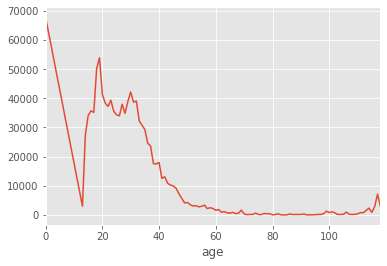

In [318]:
# age history chart
history.groupby('age').size().head(N).plot()

In [ ]:
## some tests with regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

models = [LinearRegression(n_jobs=-1), # метод наименьших квадратов
	          RandomForestRegressor(n_estimators=100, max_features ='sqrt', n_jobs=-1), # случайный лес
	          KNeighborsRegressor(n_neighbors=6, n_jobs=-1), # метод ближайших соседей
	          SVR(kernel='linear'), # метод опорных векторов с линейным ядром
              lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1)
	       ]

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trainX, Y1, test_size=0.4)


#создаем временные структуры
TestModels = pd.DataFrame()
tmp = {}


#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    print('model : ', model)
    tmp['Model'] = m[:m.index('(')]    

    model.fit(Xtrn, list(Ytrn['at_least_one'])) 
    
    #вычисляем коэффициент детерминации
    tmp['R2_Y'] = r2_score(list(Ytest['at_least_one']), model.predict(Xtest))
        
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])

#делаем индекс по названию модели
TestModels.set_index('Model')

In [ ]:
# vectorizer test
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(token_pattern='[0-9]+', dtype='UInt8')

X = vectorizer.fit_transform(validate.publishers)

#X = vectorizer.fit_transform(validate.user_ids)


print(vectorizer.get_feature_names())
print(X.shape)
print(X.toarray())

In [ ]:
# div\mul test

a1 = [1,2,3]
a2 = [1,2,3]

print(type(a1))
print(a1)

print(type(a2))
print(a2)

print()


q = np.int32(1)

#a1 = np.multiply(a1, q)

a1 = a1 * q

a2 = a2 / q + 1

print(type(a1))
print(a1)

print()

print(type(a2))
print(a2)

print(np.mean(a1))